# 1. Data Preprocessing

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP

In [2]:
# Import data

def import_train_data(dir):
    df = None
    min_cols,max_cols = (None,None)
    for file in os.listdir(dir):
        print(f"train: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])
        if df is None:
            df = _df
        else:
            df = pd.concat([df,_df])

    min_cols = df.min()
    max_cols = df.max()
    df = (df-df.min())/(df.max()-df.min())
        
    return df, min_cols, max_cols

def import_test_data(dir, min_cols, max_cols):
    dfs = []

    for file in os.listdir(dir):
        print(f"test: {file}")
        _df = pd.read_csv(f"{os.path.join(dir,file)}", sep="\t", header=None)
        _df = _df.drop(columns=[0])        
        _df = (_df-min_cols)/(max_cols-min_cols)
        dfs.append(_df)
        
    return dfs

train_df, train_min, train_max = import_train_data("/Users/faith/Desktop/Projects/tsad/data/train")
test_dfs = import_test_data("/Users/faith/Desktop/Projects/tsad/data/test", train_min, train_max)

train: 07112001.txt
train: 06112001.txt
train: 08112001.txt
train: 05112001.txt
test: 20112001.txt
test: 30102001.txt
test: 17112001.txt
test: 09112001.txt


In [3]:
# Convert to Tensors

dropout = 10
train = torch.FloatTensor(train_df[::dropout].values)

In [4]:
# Create Dataset Class

class TimewindowDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data
        self.window_size = window_size
        
    def __len__(self):
        return self.data.shape[0]-self.window_size
    
    def __getitem__(self,i):
        return (self.data[i:i+self.window_size], self.data[i+self.window_size])
    
window_size = 100
num_sensors = train.shape[1]
train_dataset = TimewindowDataset(train, window_size)
train_dataloader = DataLoader(train_dataset, shuffle=True)

# 2. Model

In [5]:
# 1D Conv + 2 GATs + GRU + FFN

class GATModel(torch.nn.Module):
    def __init__(self, window_size, num_sensors, heads=1, kernel_size=7, hidden_dim=500, n_layers=1):
        """
        n = nu
        mber timesteps
        k = number sensors
        """
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.num_sensors = num_sensors
        self.heads = heads
        self.conv_1d = nn.Conv1d(num_sensors, num_sensors, kernel_size)
        self.gat_f = GATConv(window_size-kernel_size+1, window_size-kernel_size+1, heads=heads)
        self.gat_t = GATConv(num_sensors, num_sensors, heads=heads)
        self.fc1 = nn.Linear((window_size-kernel_size+1)*(heads*2+1), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        
    def forward(self,x):
        x = self.conv_1d(x.T).T
        x1 = self.gat_feature(x)
        x2 = self.gat_time(x)
        x = torch.hstack((x.T,x1))
        for head in range(self.heads):
            x = torch.hstack((x,x2[:,head*self.num_sensors:(head+1)*num_sensors].T))
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        
        return x
    
    def complete_edge_idx(self, num_nodes):
        nodes = torch.tensor(list(range(num_nodes)))
        idx1 = nodes.repeat_interleave(num_nodes)
        idx2 = nodes.repeat(num_nodes)
        return torch.vstack((idx1,idx2))  
    
    def gat_feature(self,x):
        edge_idx = self.complete_edge_idx(x.shape[1])
        data = Data(x=x.T, edge_index=edge_idx)
        x = self.gat_f(data.x, data.edge_index)
        return x      
    
    def gat_time(self,x):
        edge_idx = self.complete_edge_idx(x.shape[0])
        data = Data(x=x, edge_index=edge_idx)
        x = self.gat_t(data.x, data.edge_index)
        return x      
    

# 3. Training

In [6]:
learn_rate=1e-4
EPOCHS = 1
model = GATModel(window_size,num_sensors,heads=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
for epoch in range(0,EPOCHS):
    for i,item in enumerate(train_dataloader):
        window, target = item
        window = window.squeeze()
        target = target.T.squeeze()
        x = model(window)
        model.zero_grad()
        loss = None
        for sensor in range(len(target)):
            if loss is None:
                loss = criterion(x[sensor].squeeze(),target[sensor])
            else:
                loss += criterion(x[sensor].squeeze(),target[sensor])
        loss.backward()
        optimizer.step()
        if i%100 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}, item {i}/{len(train_dataloader)}, loss {loss.item()}")


Epoch 1/1, item 0/34460, loss 11.331805229187012
Epoch 1/1, item 100/34460, loss 0.4512264132499695
Epoch 1/1, item 200/34460, loss 1.0257017612457275
Epoch 1/1, item 300/34460, loss 0.19848191738128662
Epoch 1/1, item 400/34460, loss 0.1638423502445221
Epoch 1/1, item 500/34460, loss 0.21695780754089355
Epoch 1/1, item 600/34460, loss 0.3753766417503357
Epoch 1/1, item 700/34460, loss 0.27877065539360046
Epoch 1/1, item 800/34460, loss 0.1800355613231659
Epoch 1/1, item 900/34460, loss 0.24215441942214966
Epoch 1/1, item 1000/34460, loss 0.17403098940849304
Epoch 1/1, item 1100/34460, loss 0.22830545902252197
Epoch 1/1, item 1200/34460, loss 0.22246505320072174
Epoch 1/1, item 1300/34460, loss 0.10395215451717377
Epoch 1/1, item 1400/34460, loss 0.2831428647041321
Epoch 1/1, item 1500/34460, loss 0.30533599853515625
Epoch 1/1, item 1600/34460, loss 0.14268502593040466
Epoch 1/1, item 1700/34460, loss 0.1952235996723175
Epoch 1/1, item 1800/34460, loss 0.15256717801094055
Epoch 1/1, it

KeyboardInterrupt: 

In [16]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

conv_1d.weight tensor([[[ 0.0254, -0.0523,  0.0067,  ...,  0.0227, -0.0145,  0.0349],
         [-0.0184, -0.0629, -0.0268,  ..., -0.0229,  0.0578, -0.0603],
         [-0.0091, -0.0440,  0.0683,  ..., -0.0060,  0.0114, -0.0409],
         ...,
         [ 0.0022, -0.0236,  0.0182,  ...,  0.0011, -0.0600, -0.0223],
         [ 0.0677,  0.0344, -0.0034,  ..., -0.0173, -0.0446,  0.0648],
         [ 0.0207,  0.0225, -0.0437,  ...,  0.0248, -0.0810, -0.0710]],

        [[ 0.0306, -0.0141, -0.0289,  ...,  0.0415,  0.0188, -0.0025],
         [ 0.0258,  0.0210, -0.0190,  ..., -0.0579,  0.0224, -0.0353],
         [-0.0232,  0.0534,  0.0639,  ...,  0.0536, -0.0438, -0.0087],
         ...,
         [-0.0754,  0.0211, -0.0761,  ..., -0.0357,  0.0193, -0.0458],
         [-0.0001, -0.0331,  0.0142,  ..., -0.0084, -0.0193, -0.0004],
         [ 0.0387,  0.0071, -0.0689,  ..., -0.0287,  0.0265, -0.0600]],

        [[ 0.0050,  0.0407, -0.0601,  ...,  0.0016, -0.0280,  0.0603],
         [-0.0360, -0.0343,  0

In [7]:
PATH = "ffn_gat.pt"
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

# 4. Eval

In [9]:
test = torch.FloatTensor(test_dfs[3][::dropout].values)
test_dataset = TimewindowDataset(test, window_size)
test_dataloader = DataLoader(test_dataset)

In [10]:
# Eval model without GRU
model.eval()
preds = None
targets = None
for i,item in enumerate(test_dataloader):
    if i%100==0:
        print(f"item: {i}/{len(test_dataloader)}")
    window, target = item
    window = window.squeeze()
    target = target.T.squeeze()
    x = model(window)
    
    if preds is None:
        preds = x.detach().numpy().reshape(-1)
    else:
        preds = np.vstack((preds,x.detach().numpy().reshape(-1)))
    if targets is None:
        targets = target.detach().numpy().reshape(-1)
    else:
        targets = np.vstack((targets,target.detach().numpy().reshape(-1)))
preds = preds*(train_max-train_min)+train_min

item: 0/8540
item: 100/8540
item: 200/8540
item: 300/8540
item: 400/8540
item: 500/8540
item: 600/8540
item: 700/8540
item: 800/8540
item: 900/8540
item: 1000/8540
item: 1100/8540
item: 1200/8540
item: 1300/8540
item: 1400/8540
item: 1500/8540
item: 1600/8540
item: 1700/8540
item: 1800/8540
item: 1900/8540
item: 2000/8540
item: 2100/8540
item: 2200/8540
item: 2300/8540
item: 2400/8540
item: 2500/8540
item: 2600/8540
item: 2700/8540
item: 2800/8540
item: 2900/8540
item: 3000/8540
item: 3100/8540
item: 3200/8540
item: 3300/8540
item: 3400/8540
item: 3500/8540
item: 3600/8540
item: 3700/8540
item: 3800/8540
item: 3900/8540
item: 4000/8540
item: 4100/8540
item: 4200/8540
item: 4300/8540
item: 4400/8540
item: 4500/8540
item: 4600/8540
item: 4700/8540
item: 4800/8540
item: 4900/8540
item: 5000/8540
item: 5100/8540
item: 5200/8540
item: 5300/8540
item: 5400/8540
item: 5500/8540
item: 5600/8540
item: 5700/8540
item: 5800/8540
item: 5900/8540
item: 6000/8540
item: 6100/8540
item: 6200/8540
item

ValueError: Length of values (8540) does not match length of index (32)

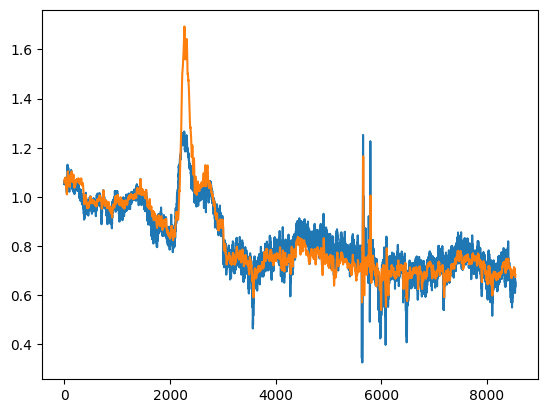

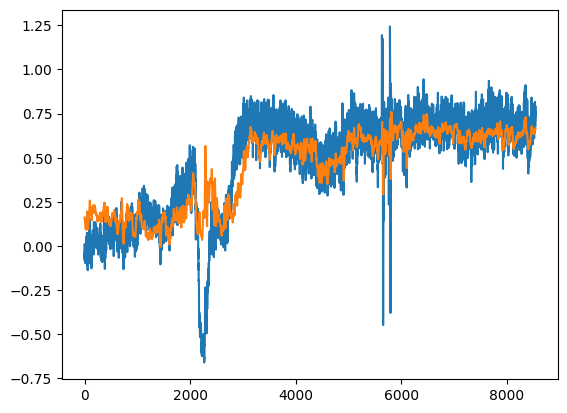

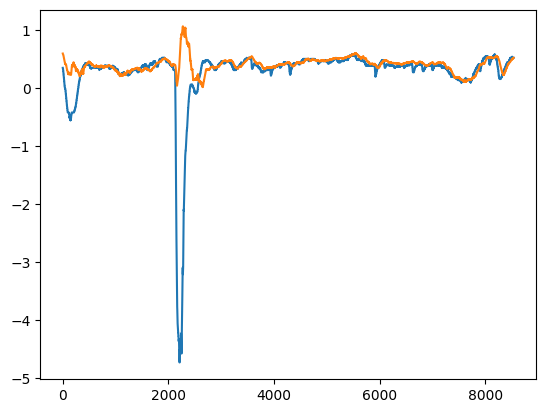

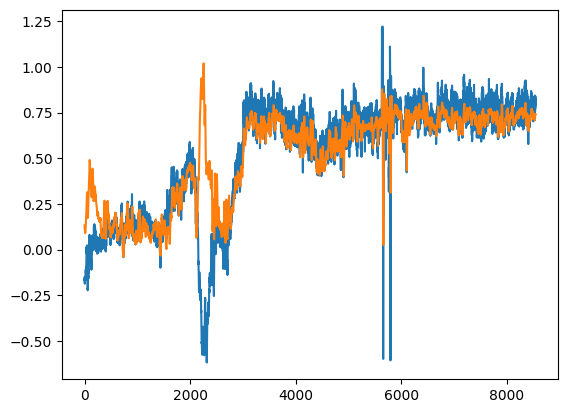

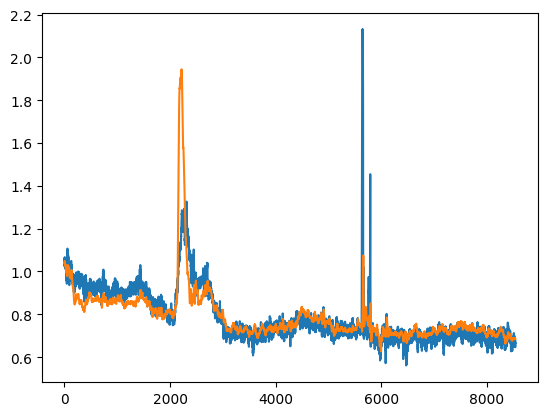

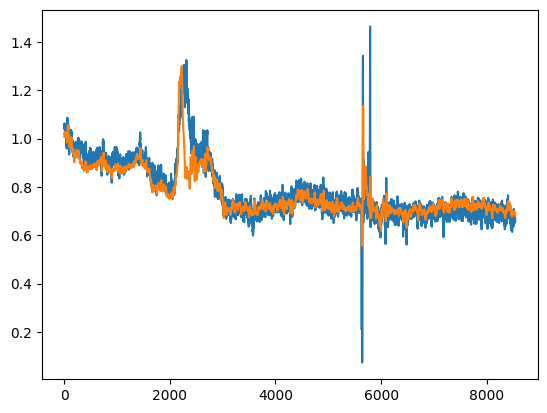

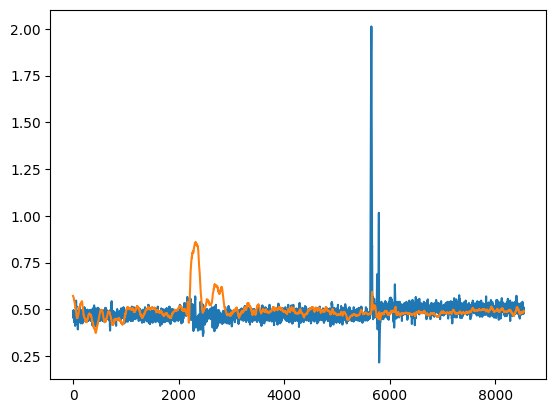

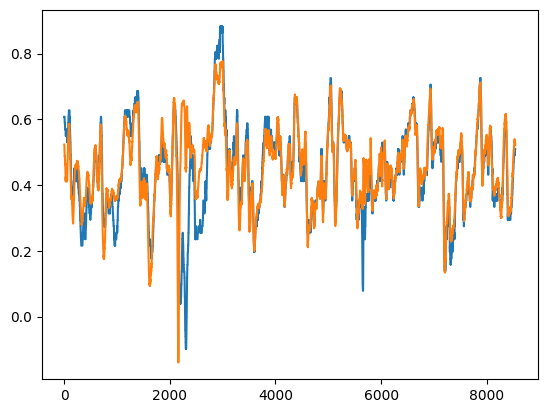

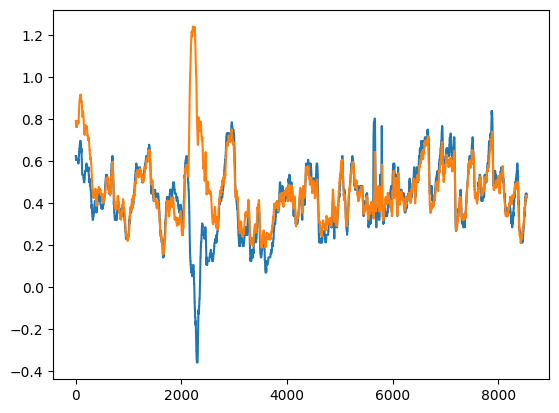

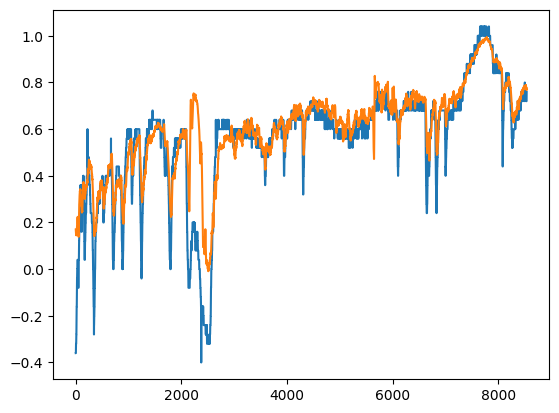

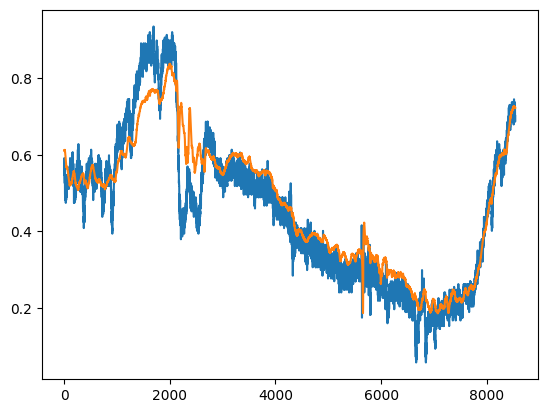

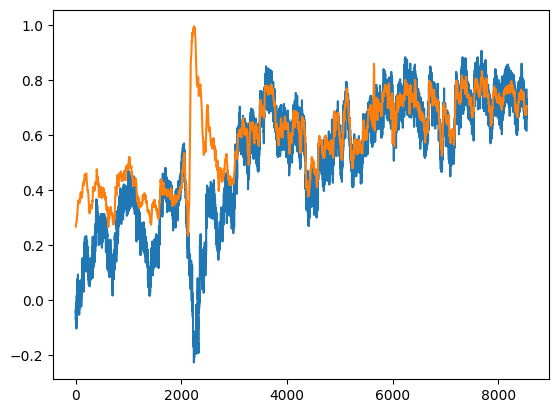

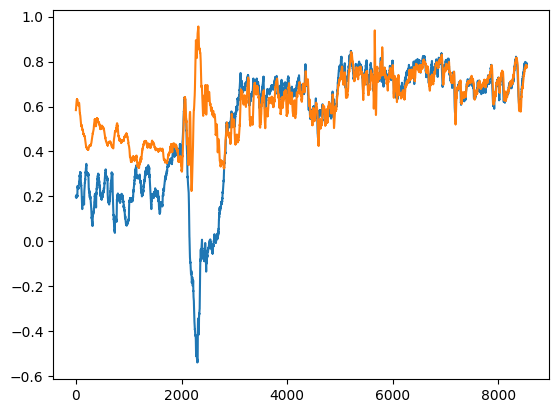

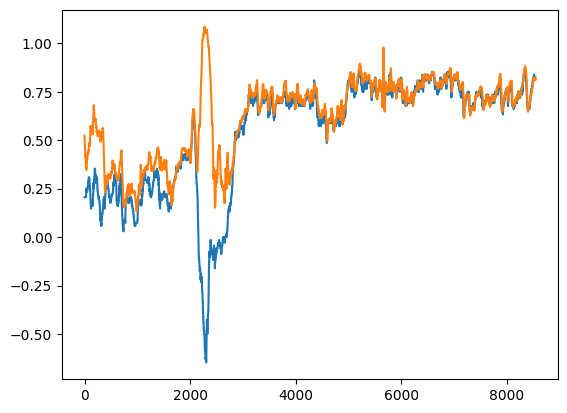

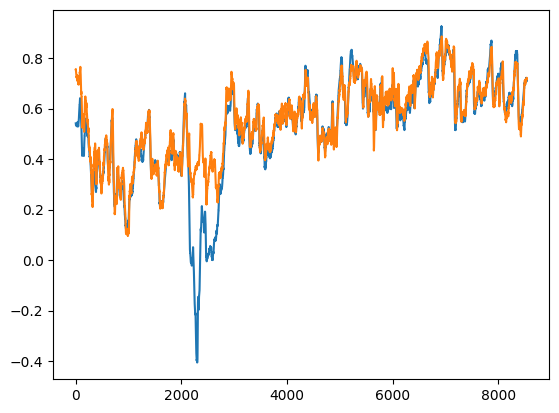

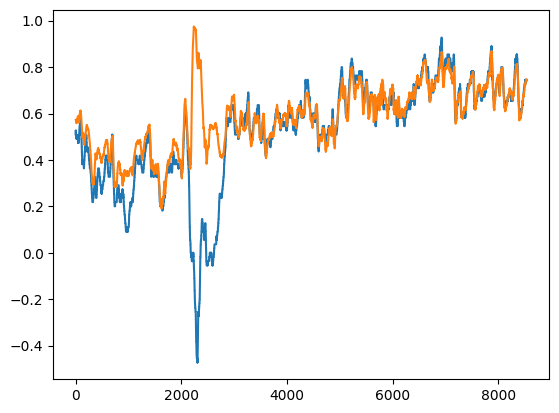

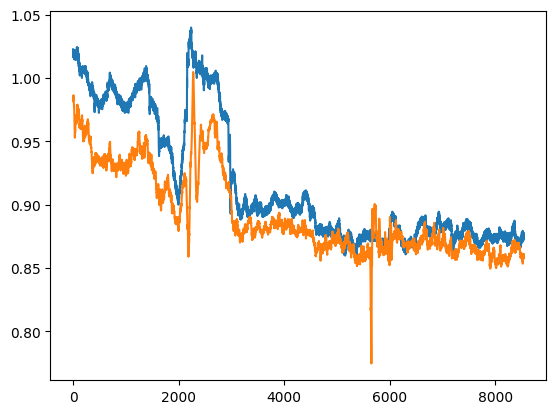

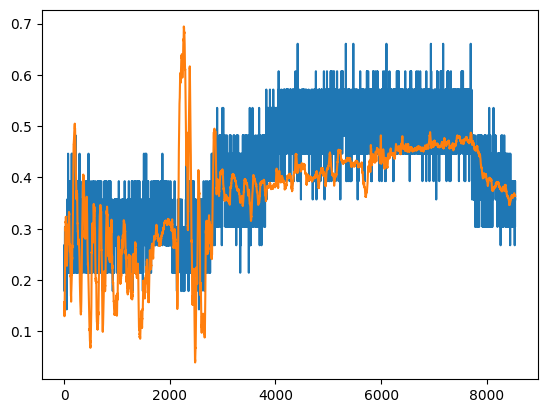

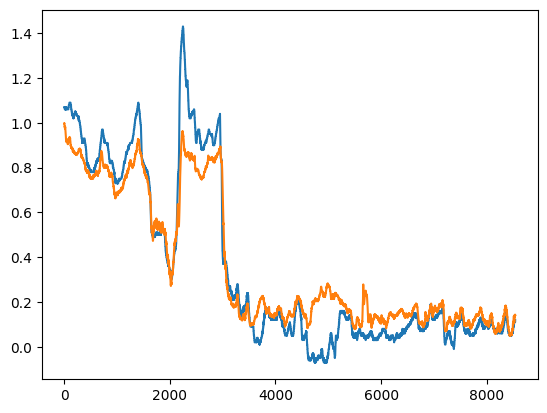

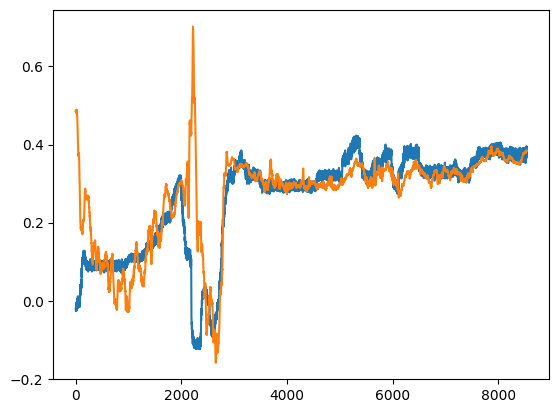

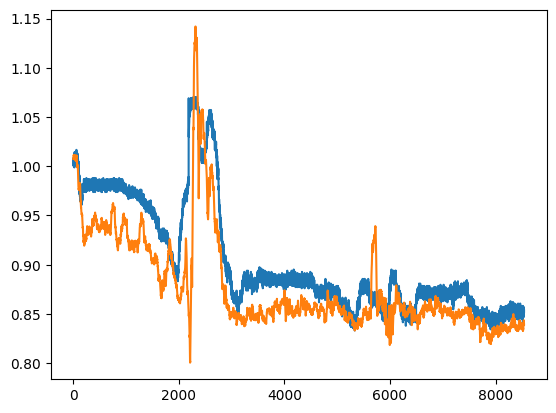

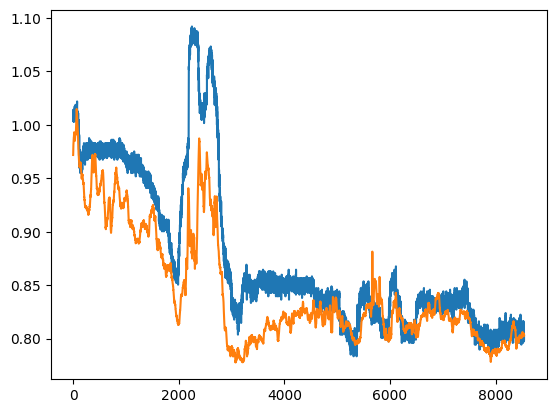

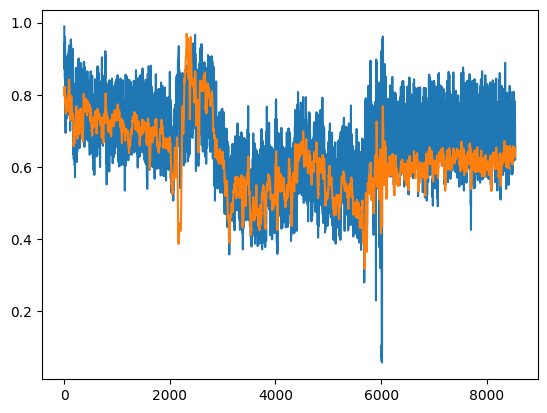

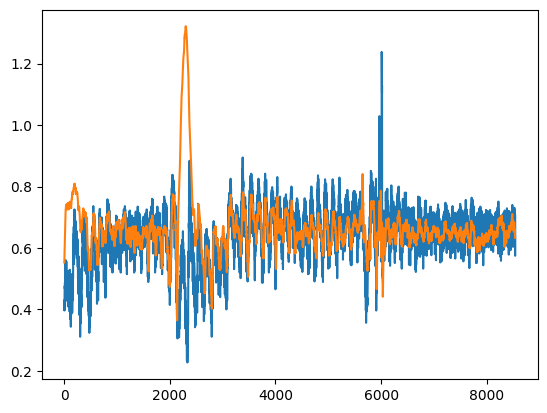

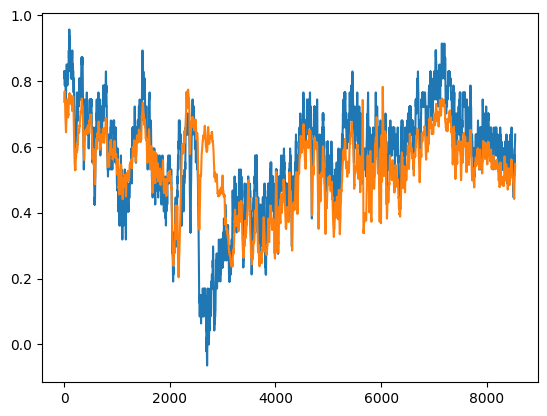

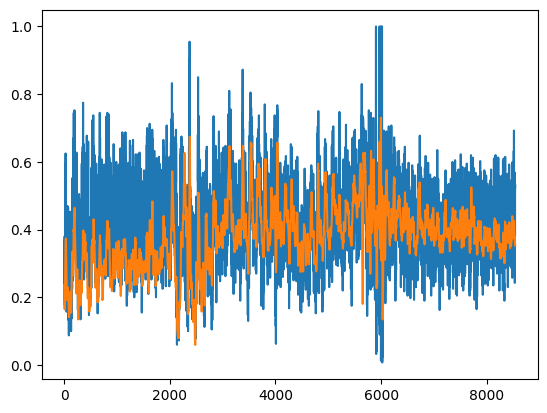

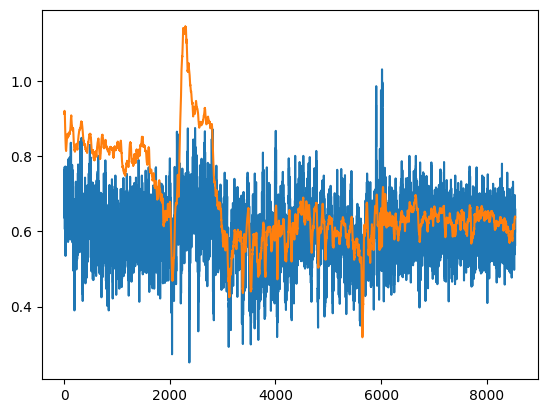

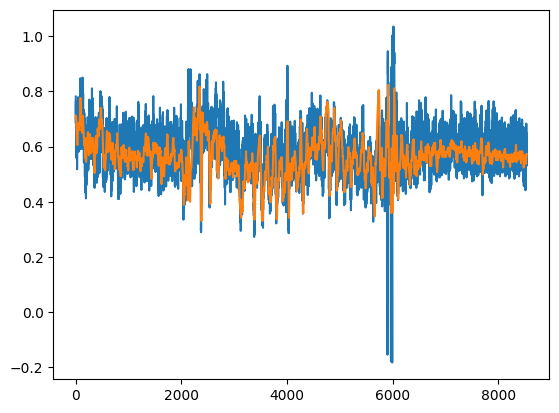

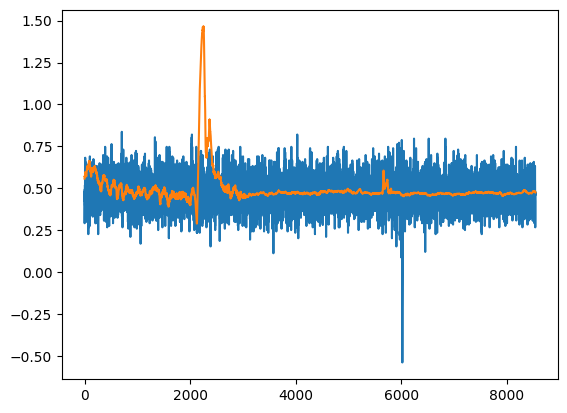

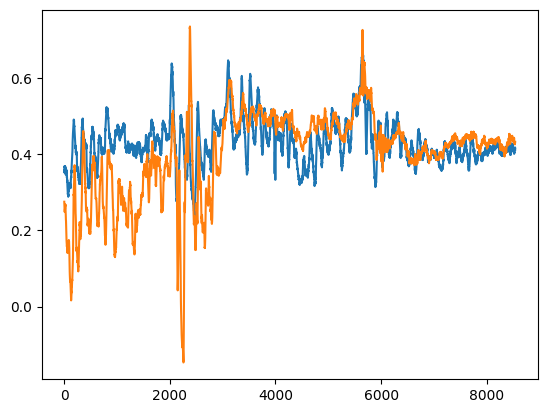

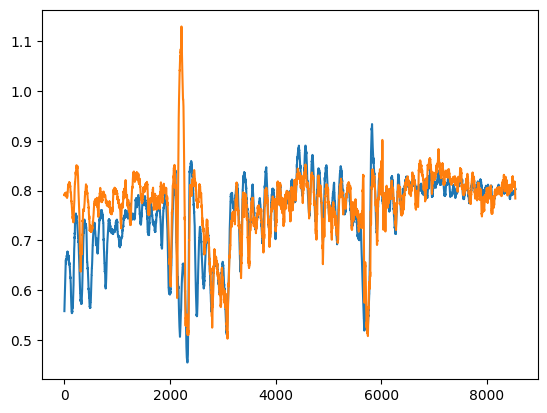

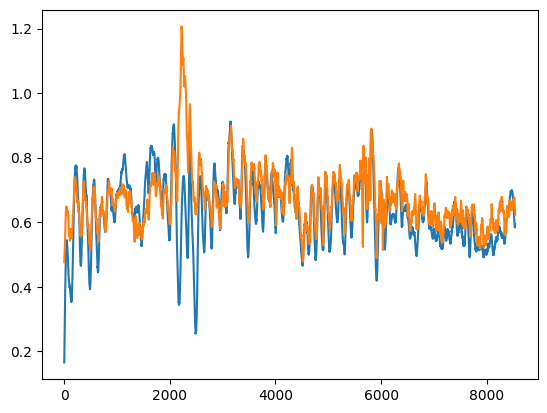

In [12]:
# With 1D Convolution and both GATs
import matplotlib.pyplot as plt

for i in range(window.shape[1]):
    plt.plot(targets[:,i], label="target")
    plt.plot(preds[:,i], label="pred")
    plt.show()